
=== Running Federated Training with SGD ===

=== Round 1 ===
Client 0: power=0.613 → batch_size=61
  → similarity with global model: 97.75% ✅ included
Client 1: power=0.030 → batch_size=2
  → similarity with global model: 58.96% ✅ included
Client 2: power=0.395 → batch_size=39
  → similarity with global model: 96.56% ✅ included
Client 3: power=0.711 → batch_size=71
  → similarity with global model: 98.10% ✅ included
Client 4: power=0.992 → batch_size=100
  → similarity with global model: 98.62% ✅ included
Client 5: power=0.754 → batch_size=75
  → similarity with global model: 98.17% ✅ included
Client 6: power=0.825 → batch_size=83
  → similarity with global model: 98.31% ✅ included
Client 7: power=0.652 → batch_size=65
  → similarity with global model: 97.88% ✅ included
Client 8: power=0.585 → batch_size=59
  → similarity with global model: 97.64% ✅ included
Client 9: power=0.567 → batch_size=57
  → similarity with global model: 97.62% ✅ included

Global Accuracy         : 52.94%
Sele

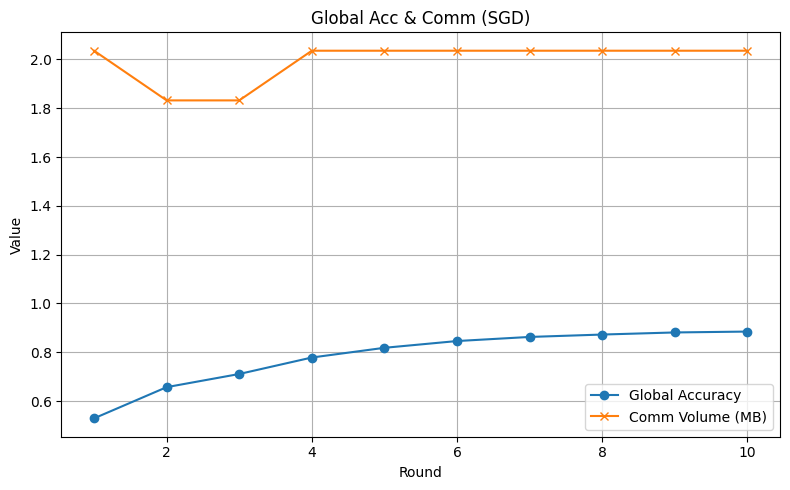

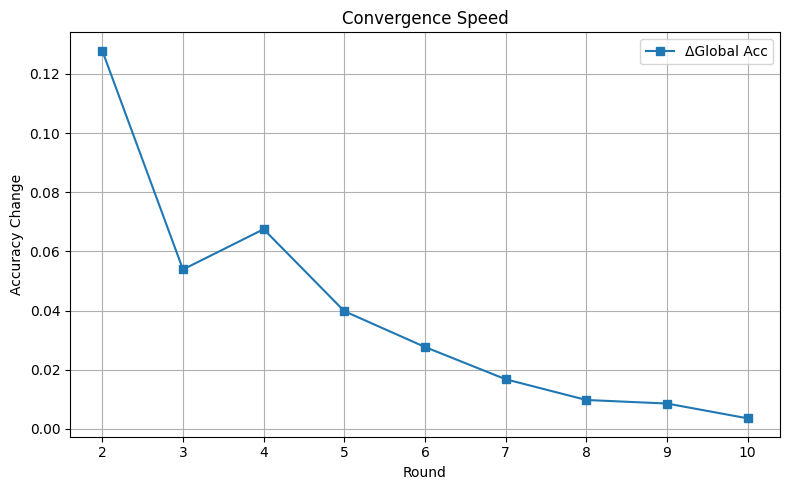

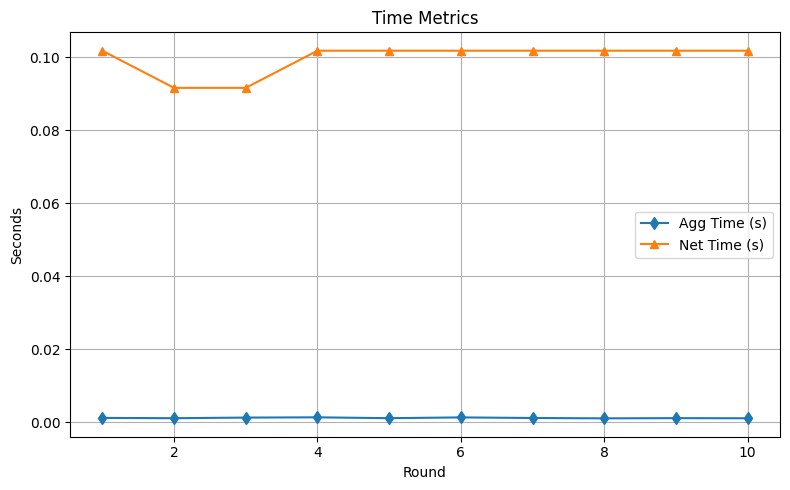


=== Running Federated Training with MGD ===

=== Round 1 ===
Client 0: power=0.962 → batch_size=100
  → similarity with global model: 68.59% ✅ included
Client 1: power=0.936 → batch_size=97
  → similarity with global model: 66.58% ✅ included
Client 2: power=0.686 → batch_size=71
  → similarity with global model: 48.13% ✅ included
Client 3: power=0.453 → batch_size=47
  → similarity with global model: 19.10% ❌ excluded
Client 4: power=0.423 → batch_size=43
  → similarity with global model: 13.19% ❌ excluded
Client 5: power=0.389 → batch_size=40
  → similarity with global model: 9.18% ❌ excluded
Client 6: power=0.778 → batch_size=80
  → similarity with global model: 55.63% ✅ included
Client 7: power=0.888 → batch_size=92
  → similarity with global model: 63.07% ✅ included
Client 8: power=0.874 → batch_size=90
  → similarity with global model: 62.11% ✅ included
Client 9: power=0.839 → batch_size=87
  → similarity with global model: 60.70% ✅ included

Global Accuracy         : 80.29%
Sele

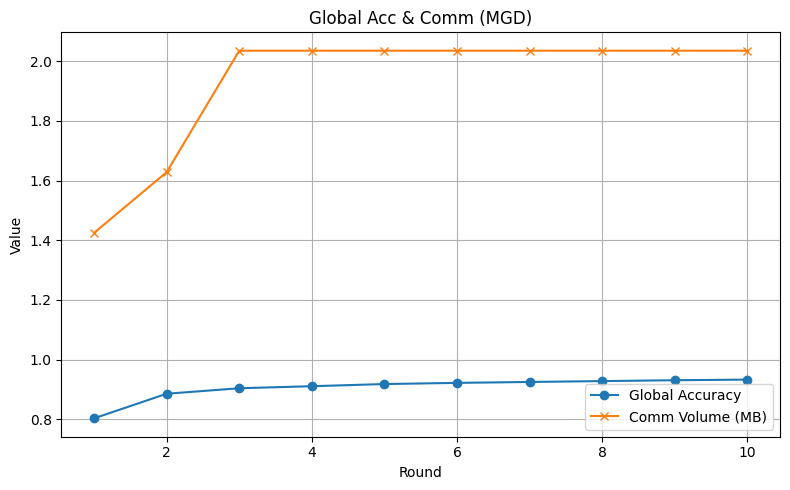

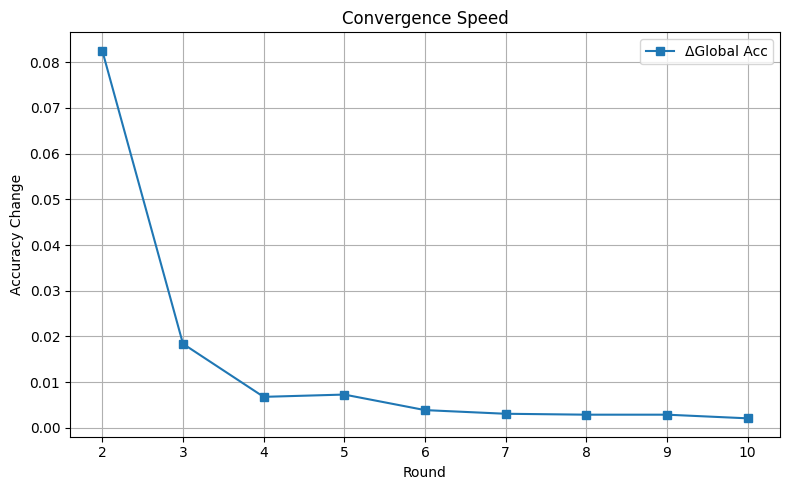

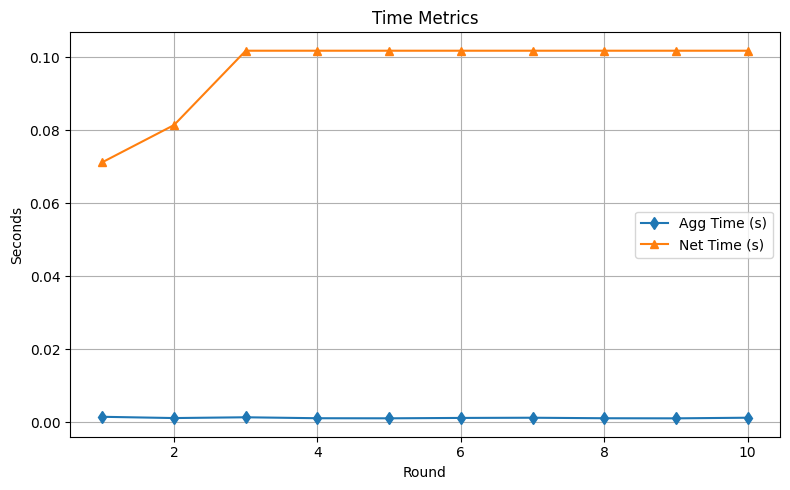


=== Running Federated Training with NAG ===

=== Round 1 ===
Client 0: power=0.843 → batch_size=100
  → similarity with global model: 87.33% ✅ included
Client 1: power=0.619 → batch_size=73
  → similarity with global model: 82.00% ✅ included
Client 2: power=0.658 → batch_size=78
  → similarity with global model: 83.27% ✅ included
Client 3: power=0.283 → batch_size=33
  → similarity with global model: 68.20% ✅ included
Client 4: power=0.663 → batch_size=78
  → similarity with global model: 83.40% ✅ included
Client 5: power=0.229 → batch_size=27
  → similarity with global model: 64.53% ✅ included
Client 6: power=0.333 → batch_size=39
  → similarity with global model: 70.80% ✅ included
Client 7: power=0.417 → batch_size=49
  → similarity with global model: 75.12% ✅ included
Client 8: power=0.509 → batch_size=60
  → similarity with global model: 78.48% ✅ included
Client 9: power=0.001 → batch_size=1
  → similarity with global model: -48.96% ❌ excluded

Global Accuracy         : 81.66%
Sel

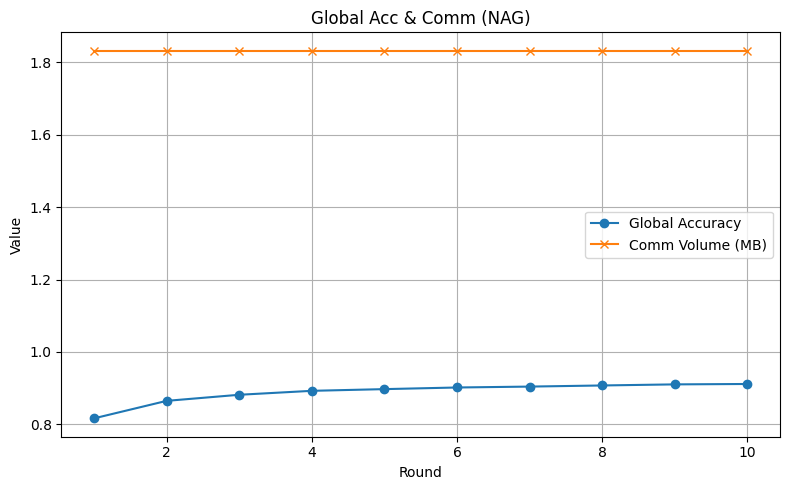

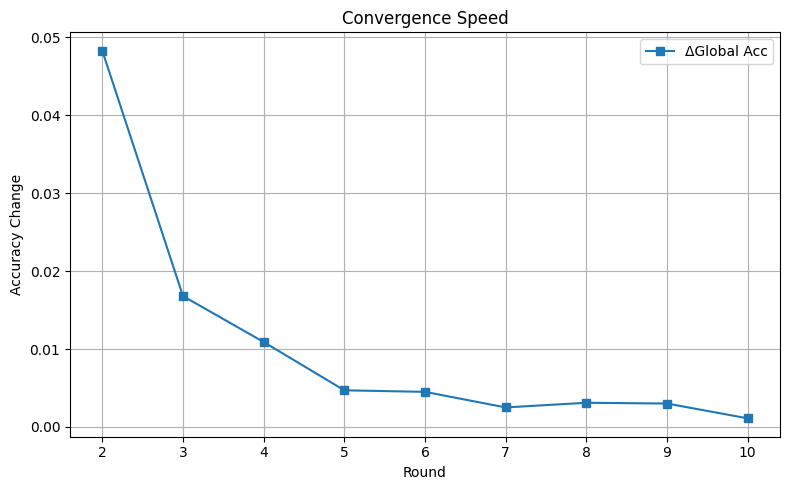

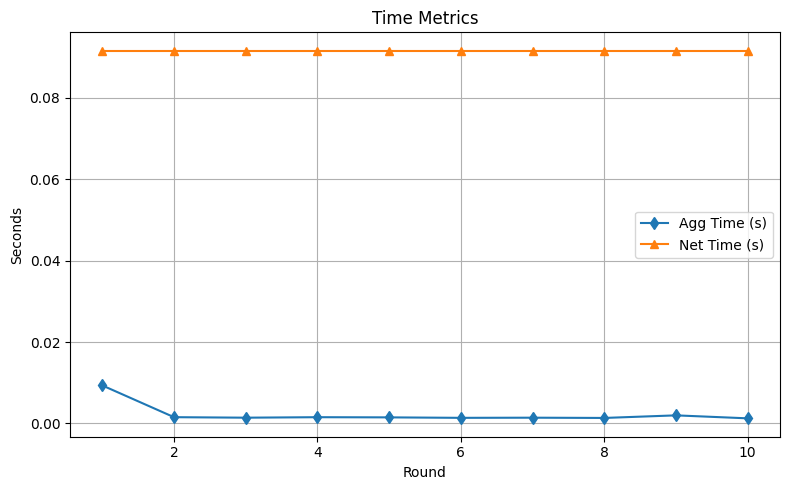


=== Running Federated Training with ADAM ===

=== Round 1 ===
Client 0: power=0.024 → batch_size=2
  → similarity with global model: -65.17% ❌ excluded
Client 1: power=0.875 → batch_size=89
  → similarity with global model: 40.24% ✅ included
Client 2: power=0.271 → batch_size=27
  → similarity with global model: 23.53% ✅ included
Client 3: power=0.120 → batch_size=12
  → similarity with global model: 8.85% ❌ excluded
Client 4: power=0.591 → batch_size=60
  → similarity with global model: 34.33% ✅ included
Client 5: power=0.973 → batch_size=100
  → similarity with global model: 40.11% ✅ included
Client 6: power=0.761 → batch_size=78
  → similarity with global model: 38.78% ✅ included
Client 7: power=0.492 → batch_size=50
  → similarity with global model: 32.35% ✅ included
Client 8: power=0.800 → batch_size=82
  → similarity with global model: 38.74% ✅ included
Client 9: power=0.355 → batch_size=36
  → similarity with global model: 28.71% ✅ included

Global Accuracy         : 90.15%
Sel

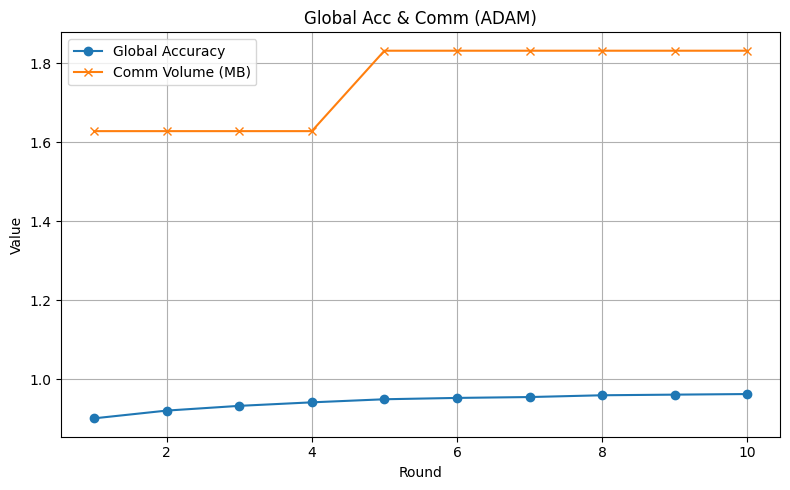

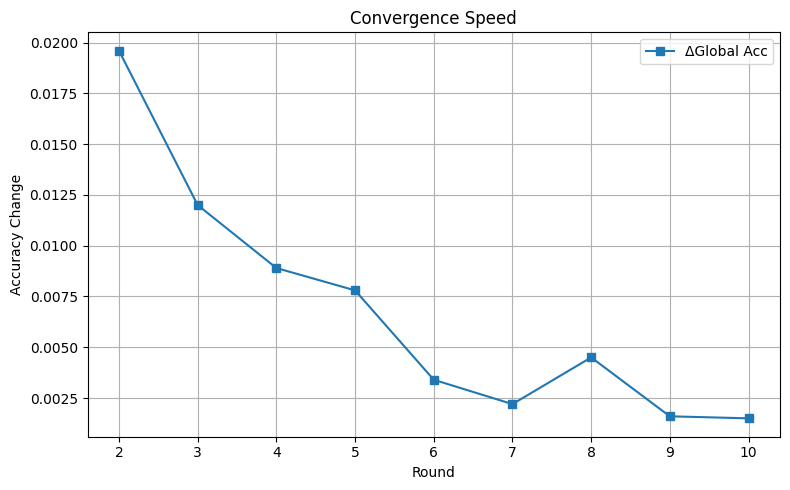

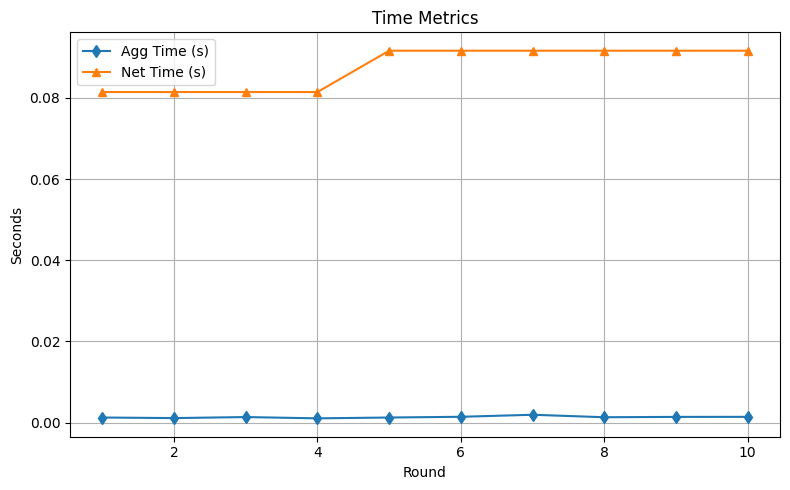

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --------- Minimal MLP Model ----------
class MinimalMLPModel(nn.Module):
    def __init__(self):
        super(MinimalMLPModel, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

# --------- Federated Training Utilities ----------
def train(model, loader, optimizer, criterion, epochs=1):
    model.train()
    for _ in range(epochs):
        for x, y in loader:
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

def similarity_score(state1, state2):
    norm_diff = 0.0
    norm_ref = 0.0
    for k in state1:
        diff = state1[k] - state2[k]
        norm_diff += torch.norm(diff).item()
        norm_ref += torch.norm(state2[k]).item()
    return 1 - (norm_diff / norm_ref)

# --------- Main Federated Learning Process ----------
def federated_training(
        optimizer_name='adam',
        num_clients=10,
        max_batch_size=100,
        rounds=10,
        bandwidth_mb_per_s=20
    ):
    client_powers = torch.rand(num_clients)
    max_power = client_powers.max()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    client_data = random_split(full_dataset, [len(full_dataset)//num_clients]*num_clients)

    global_model = MinimalMLPModel()
    criterion = nn.CrossEntropyLoss()

    global_accs, comm_volumes, agg_times, net_times, conv_speeds = [], [], [], [], []
    prev_global_acc = 0.0

    total_params = sum(p.numel() for p in global_model.parameters())




    for rnd in range(1, rounds+1):
        print(f"\n=== Round {rnd} ===")
        selected_states = []

        inclusion_threshold = 0.65 if rnd > 1 else 0.20

        for i in range(num_clients):
            ratio = (client_powers[i] / max_power).item()
            batch_size = max(1, int(ratio * max_batch_size))
            print(f"Client {i}: power={client_powers[i]:.3f} → batch_size={batch_size}")

            local_model = MinimalMLPModel()
            local_model.load_state_dict(global_model.state_dict())

            if optimizer_name == 'adam':
                optimizer = optim.Adam(local_model.parameters(), lr=0.001)
            elif optimizer_name == 'sgd':
                optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.0)
            elif optimizer_name == 'nag':
                optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
            elif optimizer_name == 'mgd':
                optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.99)
            else:
                raise ValueError(f"Unknown optimizer: {optimizer_name}")

            train_loader = DataLoader(client_data[i], batch_size=batch_size, shuffle=True)
            train(local_model, train_loader, optimizer, criterion, epochs=1)

            # Compare local model to global model using similarity score
            sim = similarity_score(local_model.state_dict(), global_model.state_dict())
            print(f"  → similarity with global model: {sim:.2%}", end='')

            if sim > inclusion_threshold:
                print(" ✅ included")
                selected_states.append(local_model.state_dict())
            else:
                print(" ❌ excluded")

        sent_clients = len(selected_states)
        comm_mb = sent_clients * total_params * 4 / 1e6
        net_time = comm_mb / bandwidth_mb_per_s

        start = time.perf_counter()
        new_state = {}
        for key in global_model.state_dict().keys():
            stack = torch.stack([state[key] for state in selected_states], dim=0)
            new_state[key] = stack.mean(dim=0)
        global_model.load_state_dict(new_state)
        agg_time = time.perf_counter() - start

        test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
        test_loader = DataLoader(test_ds, batch_size=64)
        global_acc = evaluate(global_model, test_loader)

        global_accs.append(global_acc)
        comm_volumes.append(comm_mb)
        net_times.append(net_time)
        agg_times.append(agg_time)
        if rnd > 1:
            conv_speeds.append(global_acc - prev_global_acc)
        prev_global_acc = global_acc

        print(f"\nGlobal Accuracy         : {global_acc:.2%}")
        print(f"Selected clients        : {sent_clients}/{num_clients}")
        print(f"Comm Volume             : {comm_mb:.2f} MB")
        print(f"Simulated Net Time      : {net_time:.2f} s")
        print(f"Server Aggregation Time : {agg_time:.4f} s")

    rounds_idx = list(range(1, rounds+1))

    plt.figure(figsize=(8,5))
    plt.plot(rounds_idx, global_accs, 'o-', label='Global Accuracy')
    plt.plot(rounds_idx, comm_volumes, 'x-', label='Comm Volume (MB)')
    plt.xlabel('Round'); plt.ylabel('Value')
    plt.title(f'Global Acc & Comm ({optimizer_name.upper()})')
    plt.legend(); plt.grid(True); plt.tight_layout()

    plt.figure(figsize=(8,5))
    plt.plot(rounds_idx[1:], conv_speeds, 's-', label='ΔGlobal Acc')
    plt.xlabel('Round'); plt.ylabel('Accuracy Change')
    plt.title('Convergence Speed')
    plt.legend(); plt.grid(True); plt.tight_layout()

    plt.figure(figsize=(8,5))
    plt.plot(rounds_idx, agg_times, 'd-', label='Agg Time (s)')
    plt.plot(rounds_idx, net_times, '^-', label='Net Time (s)')
    plt.xlabel('Round'); plt.ylabel('Seconds')
    plt.title('Time Metrics')
    plt.legend(); plt.grid(True); plt.tight_layout()

    plt.show()

if __name__ == '__main__':
    for opt in ['sgd', 'mgd', 'nag', 'adam']:
        federated_training(
            optimizer_name=opt,
            num_clients=10,
            max_batch_size=100,
            rounds=10,
            bandwidth_mb_per_s=20
        )
